In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit

# Model

$$\theta_i \sim N(0,1)$$
$$x_i \sim \theta_i + N(0,1)$$
$$\eta_{i} \sim Bernoulli(expit(\theta_i))$$
$$\eta_{i}' \sim Bernoulli(0.5)$$
$$z_{it} \sim \theta_i  + N(0,1)$$
$$\zeta_{t} \sim \min_i(z_{it}) + N(0,1)$$
$$y_{it} = \theta_i + z_{it} + \eta_{i} + \zeta_{t} + N(0,1)$$
$$y_{it}' = \theta_i + z_{it} + \eta_{i}' + \zeta_{t} + N(0,1)$$


In [10]:
RNG = np.random.default_rng(23435143)

In [11]:
def ols(X,y):
    if len(X.shape) == 1:
        return (X@y) / (X@X)
    else:
        return np.linalg.inv(X.T @ X) @ X.T @ y

def demean(y):
    return (y- y.mean(axis=1, keepdims=True))

In [12]:
class DataGenerator:
    def __init__(self, n, m):

        theta = RNG.normal(size=(n,1))
        x = theta + RNG.normal(size=(n, 1))
        eta = RNG.binomial(1, expit(theta), size=(n, 1))
        eta_p = RNG.binomial(1, 0.5, size=(n, 1))

        z = theta + RNG.normal(size=(n,m))
        zeta = np.min(z, axis=0).reshape((1, -1)) + RNG.normal(size=(1, m))


        theta = np.repeat(theta, m, axis=1)
        x = np.repeat(x, m, axis = 1)
        eta = np.repeat(eta, m, axis=1)
        eta_p = np.repeat(eta_p, m, axis=1)
        zeta = np.repeat(zeta, n, axis=0)

        y = theta + z + eta + zeta + RNG.normal(size=(n,m))
        y_p = theta + z + eta_p + zeta + RNG.normal(size=(n,m))

        self.theta = theta
        self.eta = eta
        self.eta_p = eta_p

        self.zeta = zeta
        self.x = x
        self.z = z
        self.y = y
        self.y_p = y_p
        self.theta_post_mean = self.x / 2

        self.n = n
        self.m = m

    def direct_ols(self):
        def get_coef(y, eta):
            X = np.stack([
                self.theta_post_mean.flatten(),
                self.z.flatten(),
                self.zeta.flatten(),
                eta.flatten(),
            ],
                         axis=-1)
            return ols(X, y.flatten())[0]

        return get_coef(self.y, self.eta), get_coef(self.y_p, self.eta_p)

    def demean_ols(self):
        z_demean = demean(self.z)
        zeta_demean = demean(self.zeta)

        def get_demean_coef(y, eta):
            y_demean = demean(y)

            delta = ols(
                np.stack([
                    z_demean.flatten(),
                    zeta_demean.flatten(),
                ],
                         axis=-1), y_demean.flatten())

            stacked_covariates = np.stack([
                self.z.flatten(),
                self.zeta.flatten(),
            ],
                                          axis=-1)

            y_minus_z = y.flatten() - stacked_covariates @ delta

            X = np.stack([
                self.theta_post_mean.flatten(),
                eta.flatten(),
            ], axis=-1)

            return ols(X, y_minus_z)[0]



        return get_demean_coef(self.y, self.eta), get_demean_coef(
            self.y_p, self.eta_p)

    def demean_ols_separate(self):
        z_demean = demean(self.z)
        zeta_demean = demean(self.zeta)
        def get_demean_coef(y, eta, mask):
            id_mask = eta==mask
            y_demean = demean(y)

            delta = ols(
                np.stack([
                    z_demean[id_mask].flatten(),
                    zeta_demean[id_mask].flatten(),
                ],
                         axis=-1), y_demean[id_mask].flatten())

            stacked_covariates = np.stack([
                self.z[id_mask].flatten(),
                self.zeta[id_mask].flatten(),
            ],
                                          axis=-1)

            y_minus_z = y[id_mask].flatten() - stacked_covariates @ delta

            X = np.stack([
                self.theta_post_mean[id_mask].flatten(),
            ], axis=-1)

            return ols(X, y_minus_z)[0]


        ans = {'cor': {}, 'ind': {}}
        for i in range(2):
            ans['cor'][i] = get_demean_coef(self.y, self.eta, i)
            ans['ind'][i] = get_demean_coef(self.y_p, self.eta_p, i)
        return ans

In [13]:
def repeat(n,m,B):
    records = []
    for b in range(B):
        data = {}
        dg = DataGenerator(n,m)
        data['direct'], data['direct_p'] = dg.direct_ols()
        data['demean'], data['demean_p'] = dg.demean_ols()
        records.append(data)
    repeat_dict = {'df': pd.DataFrame(records),
                   'n': n,
                   'm': m, 
                   'B': B,}
    return repeat_dict


def repeat_separate(n,m,B):
    records = []
    for b in range(B):
        data = {}
        dg = DataGenerator(n,m)
        ans = dg.demean_ols_separate()
        data['cor_0'], data['cor_1'] = ans['cor'][0], ans['cor'][1]
        data['ind_0'], data['ind_1'] = ans['ind'][0], ans['ind'][1]
        records.append(data)
    repeat_dict = {'df': pd.DataFrame(records),
                   'n': n,
                   'm': m, 
                   'B': B,}
    return repeat_dict



def plot_kde(repeat_dict, fname=None):
    fig, axs = plt.subplots(1,4, figsize=(15,4))

    fig.suptitle(f'n={repeat_dict['n']}, m={repeat_dict['m']}, B={repeat_dict['B']}')
    df = repeat_dict['df']
    for i, ax in enumerate(axs):
        col = df.columns[i]
        sns.kdeplot(df[col], ax=ax)
        ax.axvline(1, color='r')
    if fname:
        fig.savefig(fname)


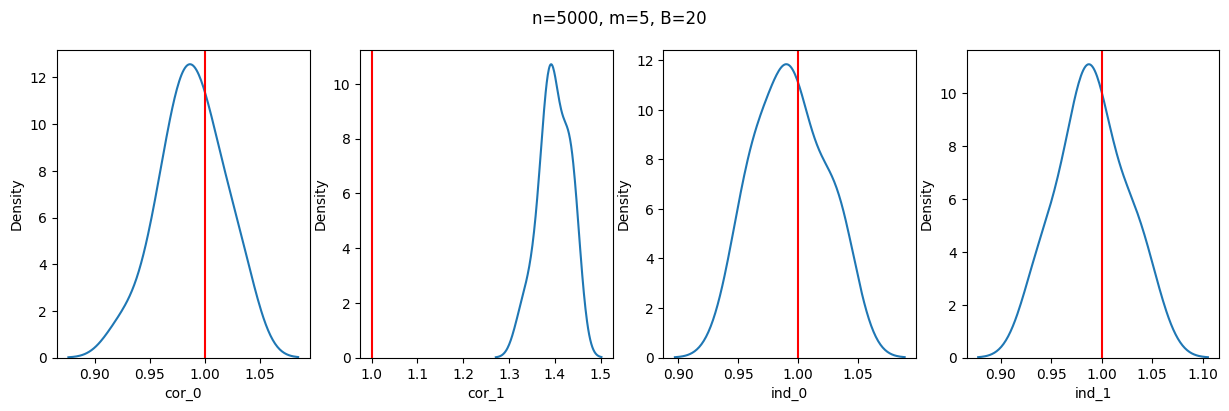

In [14]:
repeat_dict = repeat_separate(5000, 5, 20)
#base case會對
plot_kde(repeat_dict)